Imports

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

1. Train image classifier

In [3]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [26]:
# def binarize_image(image_to_be_processed):
#
#     image_to_be_processed = image.img_to_array(image_to_be_processed, dtype='uint8')
#
#     binarized_image = np.expand_dims(cv2.adaptiveThreshold(image_to_be_processed, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2), -1)
#
#     invered_image = ~binarized_image
#
#     return invered_image

# second try
def binarize_image(image_to_be_processed):
    if image_to_be_processed.shape[-1] == 3:  # Convert only if it's an RGB image
        image_to_be_processed = cv2.cvtColor(image.img_to_array(image_to_be_processed, dtype='uint8'), cv2.COLOR_RGB2GRAY)
    else:
        image_to_be_processed = image.img_to_array(image_to_be_processed, dtype='uint8')

    binarized_image = np.expand_dims(
        cv2.adaptiveThreshold(image_to_be_processed, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2),
        -1
    )

    inverted_image = ~binarized_image

    return inverted_image

In [27]:
data_dir = 'data/extracted_images'
batch_size = 32
img_height = 45
img_width = 45

In [28]:
train_datagen = ImageDataGenerator(preprocessing_function=binarize_image)

In [29]:
train_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    seed=123
)

Found 179929 images belonging to 16 classes.


Naming conventions for classes

In [30]:
class_names = [name for name, _ in train_generator.class_indices.items()]
print(class_names)

['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'div', 'times', 'y']


In [31]:
nb_of_classes = 16

model = tf.keras.models.Sequential([
    tf.keras.layers.Input((45, 45, 1)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(nb_of_classes),
    tf.keras.layers.Dense(nb_of_classes, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 45, 45, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 19, 19, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)         

In [32]:
model.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [34]:
model.fit(train_generator, epochs=5)

Epoch 1/5
5623/5623 [==============================] - 136s 24ms/step - loss: 0.0684 - accuracy: 0.9817
Epoch 2/5
5623/5623 [==============================] - 92s 16ms/step - loss: 0.0362 - accuracy: 0.9903
Epoch 3/5
5623/5623 [==============================] - 90s 16ms/step - loss: 0.0232 - accuracy: 0.9934
Epoch 4/5
5623/5623 [==============================] - 93s 16ms/step - loss: 0.0175 - accuracy: 0.9949
Epoch 5/5
5623/5623 [==============================] - 93s 17ms/step - loss: 0.0148 - accuracy: 0.9959


In [35]:
model.save('equation-detection-model-v1', save_format='tf')

INFO:tensorflow:Assets written to: equation-detection-model-v1\assets


INFO:tensorflow:Assets written to: equation-detection-model-v1\assets


In [36]:
image_directory = "equation_images/"

Definition of a function that returns the overlaps

In [37]:
def detect_overlap(x,y):
    return max(0, min(x[1], y[1]) - max(x[0], y[0]))

Definition of the function which detects the contours

Given a path to an image, it will return the bounding coordinates of the image

In [38]:
def detect_contours(image_path):

    #import the grayscale image
    input_image = cv2.imread(image_path, 0)

    copy_image = input_image.copy()

    #we convert the image into binary form, to be able to process it using the grayscale tempo
    binarized_image = cv2.adaptiveThreshold(copy_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    invered_image = ~binarized_image

    #In this step, we will find the contours, and we will keep track of the hierarchy of them
   # contours_list, hierarchy = cv2.findContours(invered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours_list, hierarchy = cv2.findContours(invered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    frames = []
    for contour in contours_list:
        x, y, w, h = cv2.boundingRect(contour)
        frames.append([x, y, w, h])

    frames_copy = frames.copy()
    keep = []

    while len(frames_copy) > 0:

        current_x, current_y, current_w, current_h = frames_copy.pop(0)

        #we will skip the very small boxes
        if current_w * current_h < 30:
            continue

        throw = []

        for i, (x, y, w, h) in enumerate(frames_copy):
            current_interval = [current_x, current_w + current_x]
            next_interval = [x, x + w]

            #Now we check if these intervals have pixels that overlap
            if detect_overlap(current_interval, next_interval) > 1:
                new_interval_x = [min(current_x, x), max(current_x + current_w, x + w)]
                new_interval_y = [min(current_y, y), max(current_y + current_h, y + h)]

                x2, y2 = new_interval_x[0], new_interval_y[0]
                w2, h2 = new_interval_x[1] - new_interval_x[0], new_interval_y[1] - new_interval_y[0]

                current_x, current_y, current_w, current_h = x2, y2, w2, h2

                #we can throw this box, because it is already merged
                throw.append(i)

        for i in sorted(throw, reverse=True):
            frames_copy.pop(i)

        # we will keep the current box to compare with the other one
        keep.append([current_x, current_y, current_w, current_h])

    return keep

In this section, we will define a flag used to keep track if the image is a handwritten one or it is generated

flag = 1 -> handwritten , 0 -> generated

In [57]:
flag = 1
example_path = "equation_images/test_image.jpg"
example_image = cv2.imread(example_path, 1)


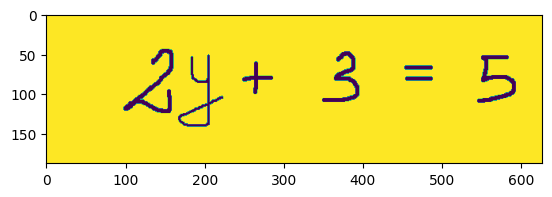

6


In [58]:
if flag == 1:
    input_image = cv2.imread(example_path, cv2.IMREAD_GRAYSCALE)
    ret, bw_img = cv2.threshold(input_image, 127, 255, cv2.THRESH_BINARY)
    plt.imshow(bw_img)
    plt.show()

    cv2.imwrite("equation_images/saved_image.jpg", bw_img)

    input_image_copy = bw_img.copy()
    keep = detect_contours(image_directory + "saved_image.jpg")
    print(len(keep))
    example_path = image_directory + "saved_image.jpg"

else:
    input_image = cv2.imread(example_path, 0)
    input_image_copy = input_image.copy()
    keep = detect_contours(example_path)
    print(len(keep))


In this section we will show how each digit is processed, by putting in a square each digit

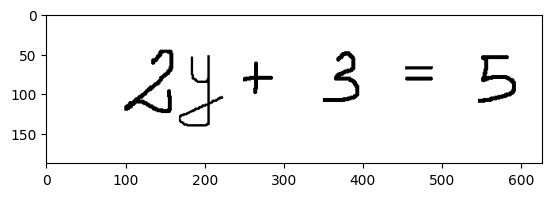

In [59]:
for (x, y, w, h) in keep:
    cv2.rectangle(input_image_copy, (x, y), (x + w, y + h), (255, 0, 0), 1)

plt.imshow(input_image_copy, cmap='gray')
plt.show()

In [60]:
def resize_image(img, size, padColor = 255):

    h, w = img.shape[:2]
    sh, sw = size

    #we use the interpolation method to evaluate the data
    if h > sh or w > sw:
        #shrink the image
        interpolation = cv2.INTER_AREA
    else:
        #stractching the image
        interpolation = cv2.INTER_CUBIC

    aspect_ratio = w / h * 1.0

    #here we will compute the scaling and the pad sizing
    if aspect_ratio > 1: #in this case we have a horizontal image
        #so, we have to modify the image in the top and bottom
        w2 = sw
        h2 = np.round(w2 / aspect_ratio).astype(int)
        pad_vertical = (sh - h2) / 2
        pad_top, pad_bottom = np.floor(pad_vertical).astype(int), np.ceil(pad_vertical).astype(int)
        pad_left, pad_right = 0, 0

    elif aspect_ratio < 1 : #vertical image
        h2 = sh
        w2 = np.round(h2 * aspect_ratio).astype(int)
        pad_horizontal = (sw - w2) / 2
        pad_left, pad_right = np.floor(pad_horizontal).astype(int), np.ceil(pad_horizontal).astype(int)
        pad_top, pad_bottom = 0, 0

    else : #square image
        #no adjustments needed
        h2 = sh
        w2 = sw
        pad_left, pad_right = 0, 0
        pad_top, pad_bottom = 0, 0

    #setting the pad and the coloring
    if len(img.shape) == 3 and not isinstance(padColor, (list, tuple, np.ndarray)):
        padColor = [padColor] * 3

    #scaling and padding
    scaled_image = cv2.resize(img, (w2, h2), interpolation=interpolation)
    scaled_image = cv2.copyMakeBorder(scaled_image, pad_top, pad_bottom, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_image

Now it's time to load our model

In [50]:
new_model = tf.keras.models.load_model('equation-detection-model-v1')

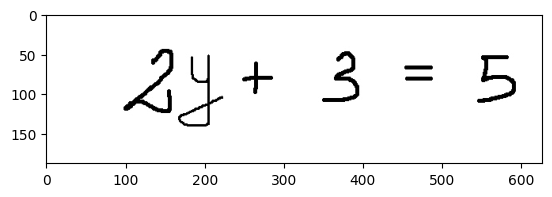

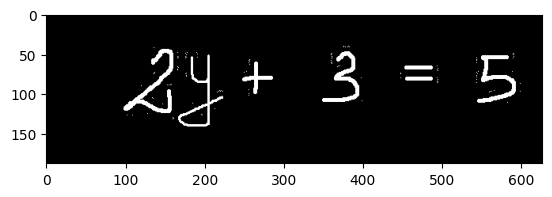

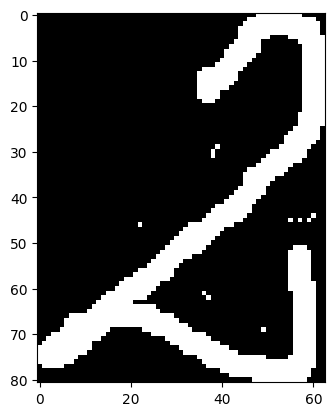

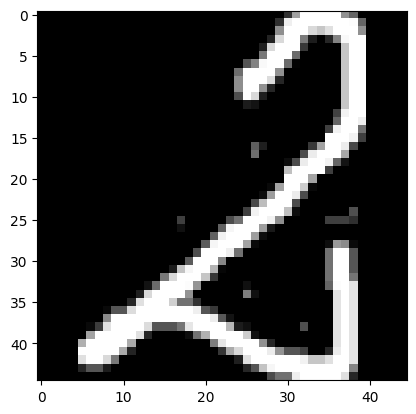

1/1 [==============================] - 0s 16ms/step
2


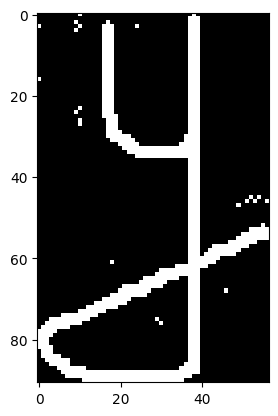

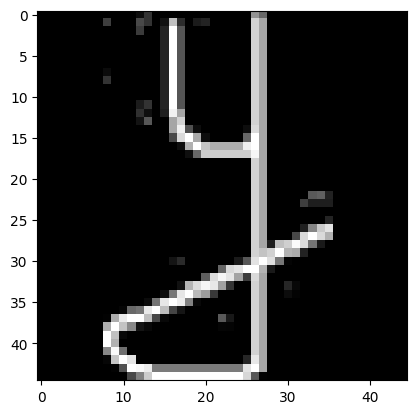

1/1 [==============================] - 0s 16ms/step
y


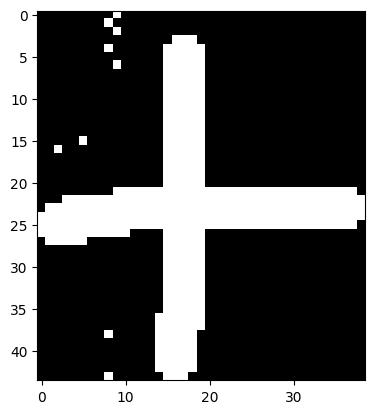

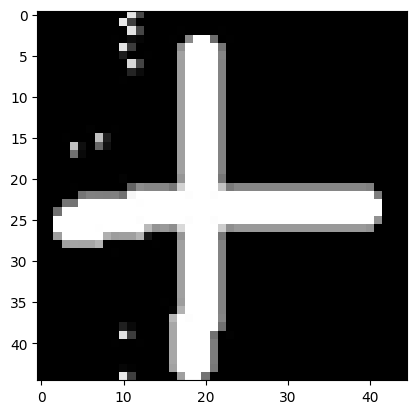

1/1 [==============================] - 0s 15ms/step
+


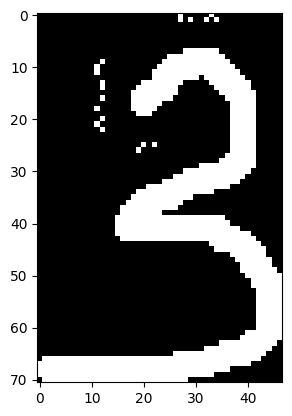

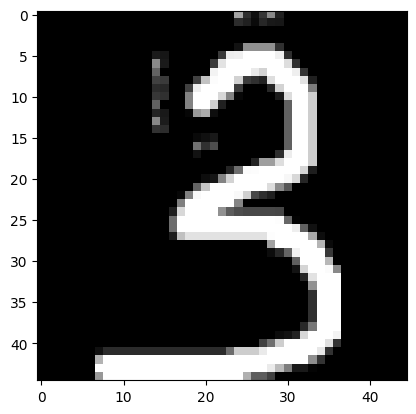

1/1 [==============================] - 0s 16ms/step
3


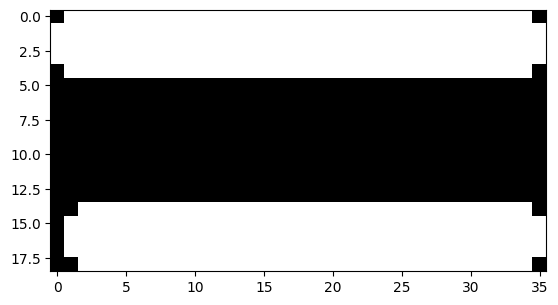

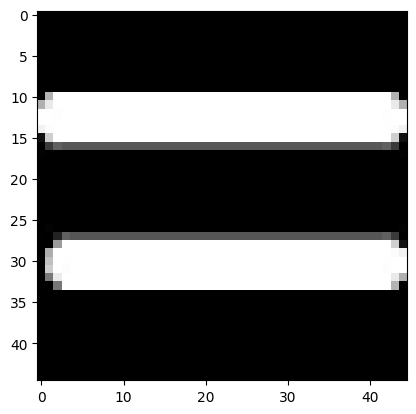

1/1 [==============================] - 0s 14ms/step
=


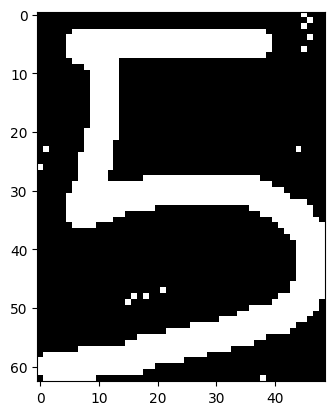

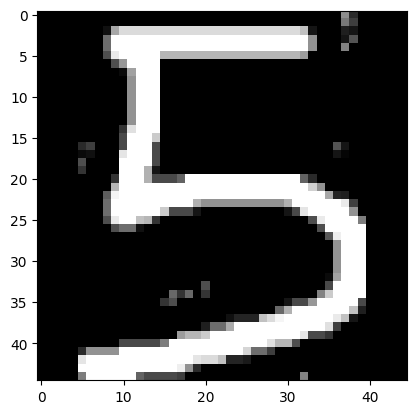

1/1 [==============================] - 0s 15ms/step
5
2y+3=5


In [61]:
eq_list = []

input_image = cv2.imread(example_path, 0)
inverted_binary_image = binarize_image(input_image)

plt.imshow(input_image, cmap='gray')
plt.show()

plt.imshow(inverted_binary_image, cmap='gray')
plt.show()

for (x, y, w, h) in sorted(keep, key = lambda x: x[0]):
    plt.imshow(inverted_binary_image[y:y+h, x:x+w], cmap='gray')
    plt.show()

    #this is the sample form of the image to be processed
    img = resize_image(inverted_binary_image[y:y+h, x:x+w], (45,45), 0)
    plt.imshow(img, cmap='gray')
    plt.show()

    prediction_class = class_names[np.argmax(new_model.predict(tf.expand_dims(tf.expand_dims(img, 0), -1)))]

    if prediction_class == "times":
        prediction_class = "*"

    eq_list.append(prediction_class)
    print(prediction_class)

eq_list = "".join(eq_list)
print(eq_list)


